In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import rasterio
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.transform import rescale
import pickle
# import mmcv

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import LossMetrics

In [4]:
import pandas as pd

In [5]:
path=Path('/home/staff/xin/Downloads/building/train/images/')
fnames=get_image_files(path)

In [6]:
names=[]
val=[]
for name in fnames:
    if name.name[-3:]=='jpg':
        names.append('train/images/'+name.name)
        val.append(0)

In [7]:
path=Path('/home/staff/xin/Downloads/building/val/images/')
fnames=get_image_files(path)

In [8]:
for name in fnames:
    if name.name[-3:]=='jpg':
        names.append('val/images/'+name.name)
        val.append(1)

In [9]:
# df=pd.DataFrame({'names':names,'val':val})

In [5]:
# df.to_csv('building.csv',index=False)

NameError: name 'df' is not defined

In [7]:
df=pd.read_csv('building.csv')

In [8]:
df.head()

,names,val
0,train/images/000000235299.jpg,0
1,train/images/000000079734.jpg,0
2,train/images/000000221494.jpg,0
3,train/images/000000147665.jpg,0
4,train/images/000000073754.jpg,0


In [9]:
path=Path('/home/staff/xin/Downloads/building')

In [10]:
def get_y_fn(x): return x.replace('jpg','png')
codes = array(['Building'])

In [11]:
size = (288,288)
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 10977MB of GPU RAM free


In [12]:
# from scipy.ndimage.morphology import distance_transform_edt
import skimage.io
from skimage.morphology import square,erosion
# from skimage.exposure import rescale_intensity
# def distance_mask(mask):
#     d = distance_transform_edt(1 - mask)
#     weights = np.ones_like(mask) + 50.0 * np.exp(-(np.power(d,2)) / (10.0 ** 2))
#     weights[d == 0] = 1
#     return weights
# from skimage.measure import label
# def get_size_weights(mask):
#     C = np.sqrt(mask.shape[0] * mask.shape[1]) / 2.0
#     sizes = np.ones_like(mask)
#     labeled = label(mask)
#     for label_nr in range(1, labeled.max() + 1):
#         label_size = (labeled == label_nr).sum()
#         sizes = np.where(labeled == label_nr, label_size, sizes)
            
#         # check for errors
        
#     sizes_ = sizes.copy()
#     sizes_[sizes == 0] = 1
#     size_weights = C / sizes_
        
#         # all non-object areas get the weight of 1
#     size_weights[sizes_ == 1] = 1
            
#     return size_weights.astype('float32')  

# class SegmentationcusLabelList(SegmentationLabelList):
#     def open(self, fn): 
#         label=skimage.io.imread(fn)
# #         label=erosion(label,square(3))
#         label[label>0]=1
#         label=np.expand_dims(label,axis=0)
# #         size=get_size_weights(label)
# #         dis=distance_mask(label)
# #         weight=np.multiply(size,dis)
# #         weight=rescale_intensity(weight,in_range=(0,75),out_range=(0,255))
# #         zeros=np.zeros_like(label)
# #         label=torch.from_numpy(np.concatenate((label,weight,zeros),axis=0).astype(np.float32, copy=False))
#         label=torch.from_numpy(label.astype(np.float32, copy=False))
#         return ImageSegment(label)   


# class SegmentationCustumList(SegmentationItemList):
#     _label_cls,_square_show_res = SegmentationcusLabelList,False

In [13]:
src=(SegmentationItemList.from_df(df,path).split_from_df(1).label_from_func(get_y_fn, classes=codes))

In [14]:
src

LabelLists;

Train: LabelList (280741 items)
x: SegmentationItemList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegmentationLabelList
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: /home/staff/xin/Downloads/building;

Valid: LabelList (60317 items)
x: SegmentationItemList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegmentationLabelList
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: /home/staff/xin/Downloads/building;

Test: None

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [16]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input,target,weight):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
#         print(weight.dtype)
#         print(loss.dtype)
        loss = loss*weight       
        return loss.mean()

class SemsegLossWeighted(nn.Module):
    def __init__(self,
                 use_running_mean=False,
                 bce_weight=0.5,
                 dice_weight=5, #0.5
                 eps=1e-10,
                 gamma=0.9,
                 use_weight_mask=True,
                 deduct_intersection=False
                 ):
        super().__init__()

        self.use_weight_mask = use_weight_mask
        
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.eps = eps
        self.focal = FocalLoss(2.0)      
        self.use_running_mean = use_running_mean
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.deduct_intersection = deduct_intersection
        self.metric_names = ['bce','dice']
        self.focal = FocalLoss(gamma)
        
        if self.use_running_mean == True:
            self.register_buffer('running_bce_loss', torch.zeros(1))
            self.register_buffer('running_dice_loss', torch.zeros(1))
            self.reset_parameters()

    def reset_parameters(self):
        self.running_bce_loss.zero_()        
        self.running_dice_loss.zero_()            

    def forward(self,
                outputs,
                targets):
        # inputs and targets are assumed to be BxCxWxH
#         outputs=outputs[:,1,:,:].unsqueeze(1)
        targets=targets.float()
#         weights=targets[:,1,:,:].unsqueeze(1)
#         targets=targets[:,0,:,:].unsqueeze(1)
        assert len(outputs.shape) == len(targets.shape)
        assert outputs.shape == targets.shape
        if self.use_weight_mask:
            weight=get_weights(targets)
            bce_loss = self.focal(outputs,targets,weight)            
        else:
            bce_loss = self.nll_loss(input=outputs,
                                     target=targets)

        dice_target = (targets == 1).float()
        dice_output = torch.sigmoid(outputs)
        dice_target = dice_target.view(-1)
        dice_output = dice_output.view(-1)
        intersection = (dice_output * dice_target).sum()
        if self.deduct_intersection:
            union = dice_output.sum() + dice_target.sum() - intersection + self.eps
        else:
            union = dice_output.sum() + dice_target.sum() + 1.0
            
        dice_loss = (-torch.log((2 * intersection+1.0) / union))         
        
        if self.use_running_mean == False:
            bmw = self.bce_weight
            dmw = self.dice_weight
            # loss += torch.clamp(1 - torch.log(2 * intersection / union),0,100)  * self.dice_weight
        else:
            self.running_bce_loss = self.running_bce_loss * self.gamma + bce_loss.data * (1 - self.gamma)        
            self.running_dice_loss = self.running_dice_loss * self.gamma + dice_loss.data * (1 - self.gamma)

            bm = float(self.running_bce_loss)
            dm = float(self.running_dice_loss)

            bmw = 1 - bm / (bm + dm)
            dmw = 1 - dm / (bm + dm)
                
        loss = bce_loss * bmw + dice_loss * dmw
        
        outloss=[bce_loss,dice_loss]
        
        self.metrics=dict(zip(self.metric_names,outloss))
        
        return loss
#     ,bce_loss,dice_loss  

def get_weights(target):
    weights=[]
    for i in range(len(target)):
        weight=torch.from_numpy(get_weight(target[i]))
        weights.append(weight)
    weights=torch.stack(weights)
    if torch.cuda.is_available():
        weights = weights.cuda().float()
    return weights
def get_weight(target):
    size_weights = get_size_weights(target)
    distance_weights = distance_mask(target)
    weights = distance_weights * size_weights
    return weights

from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt

def get_size_weights(mask):
    C = np.sqrt(mask.shape[0] * mask.shape[1]) / 2.0
    sizes = np.ones_like(mask)
    labeled = label(mask)
    for label_nr in range(1, labeled.max() + 1):
        label_size = (labeled == label_nr).sum()
        sizes = np.where(labeled == label_nr, label_size, sizes)        
    sizes_ = sizes.copy()
    sizes_[sizes == 0] = 1
    size_weights = C / sizes_
    size_weights[sizes_ == 1] = 1           
    return size_weights.astype('float32')  
def distance_mask(mask):
    d = distance_transform_edt(1 - mask)
    weights = np.ones_like(mask) + 50.0 * np.exp(-(np.power(d,2)) / (10.0 ** 2))
    weights[d == 0] = 1
    return weights


In [17]:
def dice(input, target):
    input = torch.sigmoid(input)    
    input = (input>0.5).float()
    target=target.float()
    return 2.0 * (input*target).sum() / ((input+target).sum() + 1.0)

def IoU(input, target):
    input = torch.sigmoid(input)    
    input = (input>0.5).float()
    target=target.float()
    intersection = (input*target).sum()
    return intersection / ((input+target).sum() - intersection + 1.0)

In [18]:
learn=None
model=None

In [19]:
from models.LinkNet import LinkNet152

In [20]:
model=LinkNet152(num_classes=1,pretrained=True)

In [25]:
# learn = unet_learner(data, models.resnet18,bottle=True,metrics=[dice,IoU],callback_fns=[BnFreeze,LossMetrics]).to_fp16()
# learn=Learner(data,model,metrics=[dice,IoU],callback_fns=[BnFreeze,LossMetrics]).to_fp16()
learn=Learner(data,model,metrics=[dice,IoU],callback_fns=BnFreeze).to_fp16()
learn.loss_func = SemsegLossWeighted()
# learn.loss_func=LovaszHingeLoss()

In [21]:
import lovasz_losses as L
class LovaszHingeLoss(nn.Module):
    def __init__(self):
        super(LovaszHingeLoss, self).__init__()

    def forward(self, outputs, targets):
        outputs = torch.sigmoid(outputs)
        outputs = outputs.squeeze(1)
        targets = targets.squeeze(1)
        loss = L.lovasz_softmax(outputs,targets, classes=[1], ignore=255)
        return loss
# def Floss(outputs, targets):
#     outputs = torch.sigmoid(outputs)
# #     outputs=outputs[:,1,:,:]
# #     targets=targets[:,0,:,:]
#     return L.lovasz_softmax(outputs,targets, classes=[1], ignore=255)

In [26]:
learn.load('models2_9')
# learn.loss_func = Floss

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type SemsegLossWeighted. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (280741 items)
x: SegmentationItemList
Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288)
y: SegmentationLabelList
ImageSegment (1, 288, 288),ImageSegment (1, 288, 288),ImageSegment (1, 288, 288),ImageSegment (1, 288, 288),ImageSegment (1, 288, 288)
Path: /home/staff/xin/Downloads/building;

Valid: LabelList (60317 items)
x: SegmentationItemList
Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288)
y: SegmentationLabelList
ImageSegment (1, 288, 288),ImageSegment (1, 288, 288),ImageSegment (1, 288, 288),ImageSegment (1, 288, 288),ImageSegment (1, 288, 288)
Path: /home/staff/xin/Downloads/building;

Test: None, model=LinkNet152(
  (firstconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace)
  (firstm

In [27]:
learn.loss_func=LovaszHingeLoss()

In [28]:
learn.model.unfreeze()

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


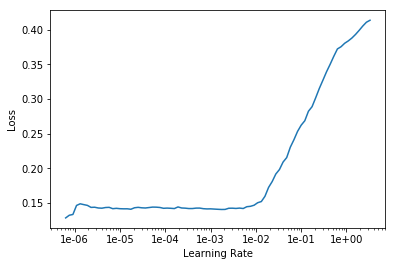

In [29]:
lr_find(learn)
learn.recorder.plot()

In [26]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(2, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,dice,IoU,time


In [33]:
# learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


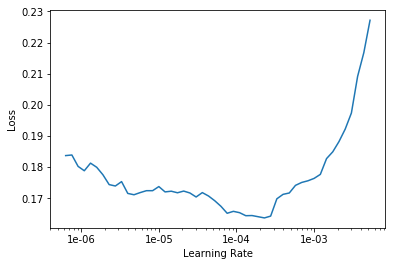

In [34]:
lr_find(learn)
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(3, slice(8e-4,1e-4))

epoch,train_loss,valid_loss,dice,IoU,bce,dice,time
0,0.173801,0.174699,0.823823,0.701259,0.106963,0.242435,00:52
1,0.173297,0.174682,0.823805,0.701258,0.106899,0.242465,00:52
2,0.173818,0.174452,0.824063,0.701597,0.106087,0.242817,00:52


## test

In [23]:
learn.load('models2_9')

Learner(data=ImageDataBunch;

Train: LabelList (280741 items)
x: SegmentationItemList
Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288)
y: SegmentationLabelList
ImageSegment (1, 288, 288),ImageSegment (1, 288, 288),ImageSegment (1, 288, 288),ImageSegment (1, 288, 288),ImageSegment (1, 288, 288)
Path: /home/staff/xin/Downloads/building;

Valid: LabelList (60317 items)
x: SegmentationItemList
Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288)
y: SegmentationLabelList
ImageSegment (1, 288, 288),ImageSegment (1, 288, 288),ImageSegment (1, 288, 288),ImageSegment (1, 288, 288),ImageSegment (1, 288, 288)
Path: /home/staff/xin/Downloads/building;

Test: None, model=LinkNet152(
  (firstconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace)
  (firstm

In [24]:
learn.export()

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type SemsegLossWeighted. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [25]:
learn = load_learner(path)

In [30]:
learn=learn.to_fp32()

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


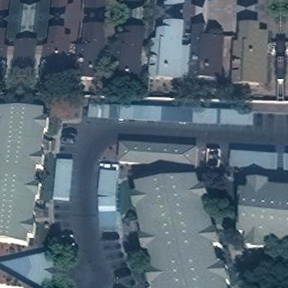

In [79]:
i=np.random.randint(1,200000)
infdata=data.train_ds[i]
xxx=learn.predict(infdata[0])
infdata[0]

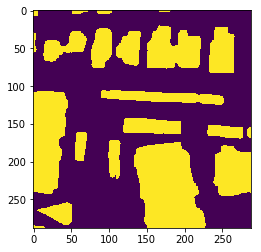

In [80]:
result=torch.sigmoid(xxx[2]).squeeze()
plt.imshow(result>0.5)